## Exploring the Data

Let's see what the data looks like.

In [139]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import pandas as pd
from fastai.metrics import error_rate

In [116]:
path = 'data/'

np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder='train', csv_labels='train_labels.csv', suffix='.tif', valid_pct=0.1,
        ds_tfms=get_transforms(), size=96, num_workers=4).normalize(imagenet_stats)

## Looking at the Data

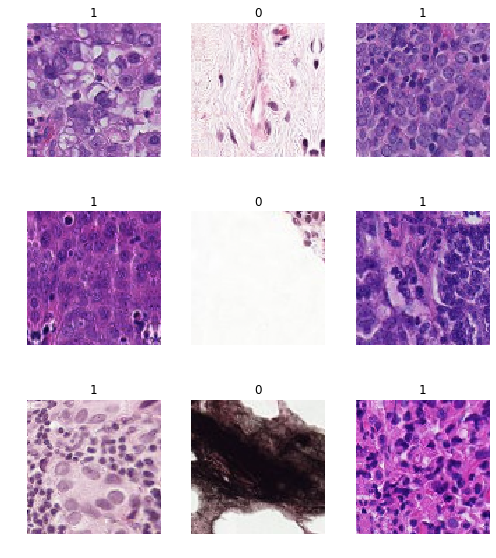

In [117]:
data.show_batch(rows=3, figsize=(7,8))

In [118]:
def josh_accuracy(input, targs):
    targs = targs.long()
    return error_rate(input, targs)

In [121]:
learner = create_cnn(data, models.resnet50, metrics=accuracy)

In [123]:
learner = create_cnn(data, models.resnet50, metrics=accuracy)
learner.unfreeze()
learner.fit_one_cycle(10, max_lr=slice(1e-5,2e-2))

epoch,train_loss,valid_loss,accuracy
1,0.223032,0.192369,0.928097
2,0.210850,0.161530,0.939915
3,0.195829,0.157612,0.945369
4,0.164323,0.142184,0.949096
5,0.143654,2.561107,0.946414
6,0.125199,0.112791,0.958595
7,0.109641,0.105122,0.963958
8,0.099911,0.094606,0.968185
9,0.092641,0.088182,0.969957
10,0.087065,0.088666,0.969912


In [125]:
learner.export()

In [147]:
learner = load_learner(path, test=ImageImageList.from_folder(path + 'test'))

In [162]:
preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)

In [163]:
preds

tensor([[3.0695e-04, 9.9969e-01],
        [9.7161e-01, 2.8392e-02],
        [9.9982e-01, 1.8206e-04],
        ...,
        [7.5287e-03, 9.9247e-01],
        [9.9998e-01, 1.5886e-05],
        [1.5325e-05, 9.9998e-01]])

In [149]:
# get test id's from the sample_submission.csv and keep their original order
SAMPLE_SUB = 'data/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in preds]

In [167]:
# To know the id's, we create a dict of id:pred
pred_dic = dict((str(key), value[1].numpy()) for (key, value) in zip(learner.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['data/test/' + id + '.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('submission.csv', header=True, index=False)